In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Include title and greeting with divs</div>

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from tqdm.notebook import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from tfl_training_sbi import mdn


# Conditional Density Estimation

_"In statistics, probability density estimation or simply density estimation is the construction of an **estimate, based on observed data**, of an unobservable underlying probability density function."_ (Wikipedia)

todo: why do we want to do it, i.e. motivation; what will be covered

## Density Estimation 

Given samples $\theta_i,~i=1,\dots,n$ with $\theta_i \sim p(\theta)$ but $p(\theta)$ **unknown**.

Goal: find $\hat{p}(\theta) \approx p(\theta)$.
<figure>
  <center>
  <img src=_static/images/density_est_species.png style="width:45%"/>
    <figcaption>Fig.1 - Plot from <a href"https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html">scikit-learn</a></figcaption>
</figure>

## Methods for Density Estimation

- Histograms
- Kernel density estimation 
- Non-parametric approaches 
- Neural networks (VAEs, GANs, Normalizing Flows, ...)

## Example: Likelihood Estimation

Given observations $\theta_i,~i=1,\dots,n$, find $\hat{p}(\theta)$

- Assumption: Data follows Normal distribution 
- Maximize Likelihood of $\theta_i$ under $\hat{p}$
- Find $\mu, \sigma$ where $\hat{p} := \mathcal{N}(\mu, \sigma)$

$$
\mu^{\prime}, \sigma^{\prime} = \underset{\mu, \sigma}{\operatorname{argmin}} - \sum_i^n \log \mathcal{N}(\theta_i; \mu, \sigma)
$$

<figure>
    <center>
    <img src="_static/images/density_est_toy_example_gauss.png" style="width:50%"/>
    <figcaption>Fig. 2 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Conditional Density Estimation

Target is conditioned on a random variable: $p(\theta) \longrightarrow p(x \mid \theta)$

Goal: density estimate for $x$ **given** an observation $\theta^{\prime}$, e.g.

$$
p(\text{drop=off} \mid \text{pick-up}=\theta) = p(x \mid \theta)
$$

<figure>
    <center>
    <img src="_static/images/taxi.png" style="width:50%"/>
    <figcaption>Fig. 3 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Parametric Conditional Density Estimation

Given a fixed value $\theta$, parameterize a probability density over data $x$.
E.g. compute the conditional mean and variance of a Gaussian distribution using a function $f(\theta)$.

$$
p(x \mid \theta) = \mathcal{N}(x; \mu(\theta), \sigma(\theta))
$$

Note, $f$ can be any function, e.g. a neural network.

Estimate the distribution parameters $\mu(\theta), \sigma(\theta)$ of

$$
p(x \mid \mu(\theta), \sigma(\theta)) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x-\mu(\theta))^2}{2\sigma^2(\theta)})
$$

by minimizing the negative log-Likelihood of the data under the model.

$$
\mathcal{L}(x, \theta) = - \sum_i \log \mathcal{N}(x_i; \mu(\theta_i), \sigma(\theta_i))
$$

Note, this is closely related to Bayesian linear regression.

## Example: Parametric Conditional Density Estimation

Given observations $x = \theta + 0.3\sin(2 \pi \theta) + \epsilon$ with $\theta
\sim \mathcal{U}(0,1)$ and $\epsilon \sim \mathcal{N}(0, 0.05)$.

Approximate $p(x \mid \theta = 0.1)$.

<figure>
    <center>
    <img src="_static/images/cde_gaussian.png" style="width:50%"/>
    <figcaption>Fig. 4 - Conditional density estimation with parametric Gaussian. Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Create  the Dataset 

In [6]:
sample_size = 10_000
dim = 1

theta = torch.rand((sample_size, dim))
noise = torch.rand((sample_size, dim)) * 0.2

x = theta + 0.3 * torch.sin(2 * math.pi * theta) + noise


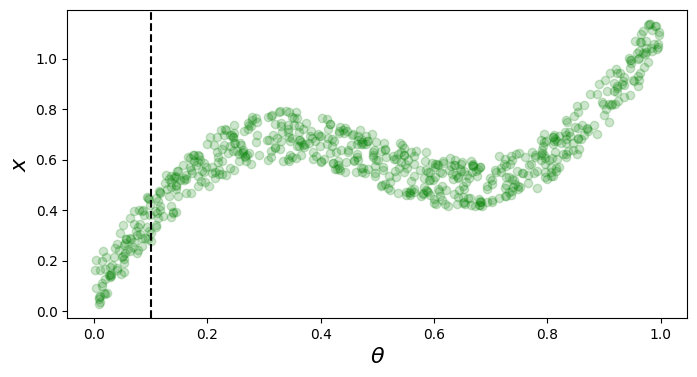

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(theta[::15], x[::15], "go", alpha=0.2)
plt.axvline(0.1, color="black", linestyle="--")
plt.ylabel("$x$", fontsize=16)
plt.xlabel("$\\theta$", fontsize=16)
plt.show()


**Task:** Train a neural network to estimate the parameters $\mu(\theta), \sigma(\theta)$ to the above density model. 

To do so, you have to create a torch Dataset and DataLoader containing `theta` and `x`. Further, you have to specify a small network with a suitable output dimension and an optimizer. Finally, you have to define the training loop in which the neg. log-Likelihood loss is minimized.

You can use the following structure to do so.

```python
dataset = # todo dataset of theta and x

train_loader = # todo: dataloader to the above dataset

# define a simple neural network to parameterize the conditional density
net = nn.Sequential(
    # todo: define model 
)

opt = # todo: define an optimizer 

# train the neural network for 100 epochs
for e in trange(100):
    for (
        theta_batch,
        x_batch,
    ) in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:, 1]).unsqueeze(1)
        prob_Gauss = # todo: implement neg. log-Likelihood loss using assuming a Gaussian distr.
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()
```

In [8]:
dataset = TensorDataset(theta, x)

train_loader = DataLoader(dataset, batch_size=20)

# define a simple neural network to parameterize the conditional density
net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 2)
)

opt = Adam(net.parameters(), lr=0.001)

# train the neural network for 100 epochs
for e in trange(100):
    for (
        theta_batch,
        x_batch,
    ) in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:, 1]).unsqueeze(1)
        prob_Gauss = (
            1
            / torch.sqrt(2 * math.pi * std**2)
            * torch.exp(-0.5 / std**2 * (mean - x_batch) ** 2)
        )
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()


  0%|          | 0/100 [00:00<?, ?it/s]

## Inspecting the Learned Distribution


In [9]:
theta_cond = torch.Tensor([0.1])
estimated_params = net(theta_cond)

cond_mean, cond_std = (
    estimated_params[0].detach().numpy(),
    torch.exp(estimated_params[1]).detach().numpy(),
)

print(f"Estimated mean: {cond_mean:.3f} and sigma: {cond_std:.3f}")


Estimated mean: 0.392 and sigma: 0.063


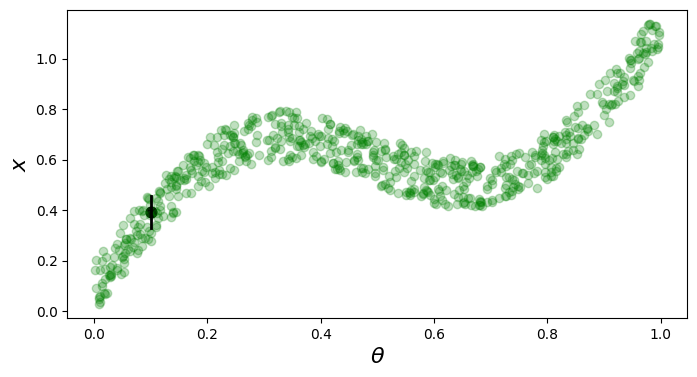

In [10]:
plt.figure(figsize=(8, 4))

plt.plot(theta[::15], x[::15], "go", alpha=0.25)
plt.plot(
    [theta_cond[0], theta_cond[0]],
    [cond_mean - cond_std, cond_mean + cond_std],
    "k-",
    linewidth=2,
)
plt.scatter(theta_cond[0], cond_mean, c="k", s=60)

plt.ylabel("$x$", fontsize=16)
plt.xlabel("$\\theta$", fontsize=16)

plt.show()


In [11]:
# todo: eval. the density est. for all thetas to show that it is a good fit


## The Problem in the Approach

- The density model is **too simple** to capture the true distribution
- Realistic distributions are more complex than a single Gaussian

## Example: Switching $\theta$ and $x$ above

- yields $\theta = g(x)$
- $\hat{p}(\theta \mid x = 0.5) = \mathcal{N}(\theta; \mu(x)=0.44, \sigma(x)=0.22)$ 

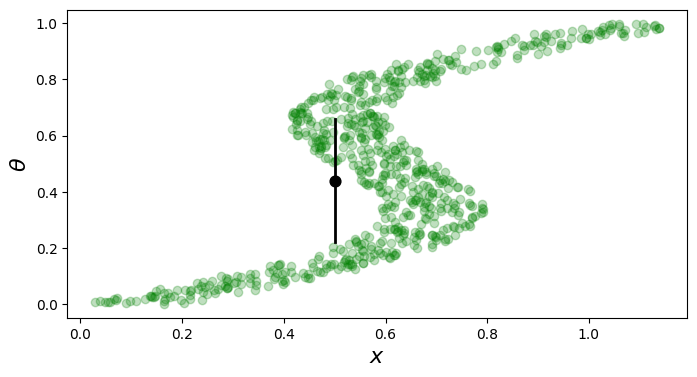

In [12]:
plt.figure(figsize=(8, 4))

plt.plot(x[::15], theta[::15], "go", alpha=0.25)
plt.plot(
    [0.5, 0.5],
    [0.44 - 0.22, 0.44 + 0.22],
    "k-",
    linewidth=2,
)
plt.scatter(0.5, 0.44, c="k", s=60)

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$\\theta$", fontsize=16)

plt.show()


## Mixture Density Networks

Instead of a single Gaussian, a linear combination of $k$ Gaussians is used. Each
Gaussian distribution can be parameterized. 

\begin{align}
\mathcal{L} &= - \sum_{i=1} \log q(\theta_i \mid x_i) \\
 &= - \sum_{i=1} \log \sum_{j=1}^k \alpha_j \mathcal{N}(\theta_i; \mu_j(x_i), \sigma_j(x_i))
\end{align}

The mixture weights $\alpha_j$, means $\mu_j$ and (co-)variances $\sigma_j$ are
learned. 

## Train a Mixture Density Network

Use a MDN to parameterize a mixture of Gaussians to approximate 
the distribution of the data shown above. 

In [13]:
# prepare data set and data loader
# note, the x and theta are swapped compared to the previous example
dataset = TensorDataset(x, theta)
train_loader = DataLoader(
    dataset,
    batch_size=128,
)


**Task:** Define a Mixture Density Network using the `MultivariateGaussianMDN` class, provided by the `mdn` module. The object takes four parameters, which you have to define. 

1. `features`: number of free parameters 
2. `hidden_net`: a neural network used for feature extraction; this can be `None` but should be constructed in a way that important information can be extracted from the incoming data
3. `num_components`: number $k$ from above, i.e. the number of Gaussians in the linear combination 
4. `hidden_features`: vector size of the output from the feature extractor 

Feel free to use the following structure. 

```python
mixture_density_net = mdn.MultivariateGaussianMDN(
    features= ,         # todo: set the number of variables
    hidden_net= ,       # todo: define a feature extractor network
    num_components= ,   # todo: define the number of Gaussians 
    hidden_features= ,  # todo: define the output dimension of the feat. extractor 
)
```

In [14]:
# initialize the mixture density network, parameterizing a
# `num_components`-component mixture of Gaussians with `features`
# features, i.e. variables
mixture_density_net = mdn.MultivariateGaussianMDN(
    features=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
    ),
    num_components=5,
    hidden_features=30,
)


In [15]:
# fit MDN using negative log-likelihood loss
opt = Adam(mixture_density_net.parameters(), lr=0.001)
for e in trange(200):
    for x_batch, theta_batch in train_loader:
        opt.zero_grad()

        # get the mixture components
        (
            weights_of_each_gaussian,
            means,
            variances,
        ) = mixture_density_net.get_mixture_components(x_batch)

        # compute Likelihood of sample under current parameterization
        log_probs = mdn.mog_log_prob(
            theta_batch, weights_of_each_gaussian, means, variances
        )

        loss = -log_probs.sum()
        loss.backward()
        opt.step()


  0%|          | 0/200 [00:00<?, ?it/s]

## Inspecting the Learned Distribution

Sample `500` times from learned posterior distribution for $x \in [0., 1.]$.

In [16]:
samples = []
x_test = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in tqdm(x_test):
    # compute the mixture components
    weights, means, variances = mixture_density_net.get_mixture_components(
        single_x.unsqueeze(1)
    )
    # sample form mixture of Gaussians
    sample = mdn.mog_sample(weights, means, variances)

    samples.append(sample)

samples = torch.cat(samples).detach().numpy()


  0%|          | 0/500 [00:00<?, ?it/s]

## Conditional Density Estimation

Condition posterior and sample `100` times from $\theta^{\prime} \sim p(\theta \mid x = 0.5)$.

**Task:** Use the trained posterior approximator to compute the conditional distribution over $\theta$, given an observation, e.g. $x_{\text{obs}} = 0.5$.

Therefore, obtain the parameters for the Gaussian mixture using the `.get_mixture_components(..)` method of the density estimator object defined above. Then, use the `mog_log_prob(..)` function of the `mdn` module (inside a loop) to evaluate the density of all $\theta_i$ along the axis of $x_{\text{obs}}$.

In order to stick with following cells, please store the obtained densities in a tensor called `demo_probs`.

Feel free to use the following structure.

```python
# chose value to condition on & compute the mixture components
x_demo = torch.as_tensor([[..]])  # todo: define the observation
logits, means, variances = # todo: obtain mixture parameters 

demo_probs = []

for t_demo in tqdm(torch.linspace(-0.1, 1.0, 100)):
    # todo: compute probability of different values of theta for the current parameterization
    # ..

demo_probs = torch.stack(demo_probs).detach().exp()
```


In [ ]:
# chose value to condition on & compute the mixture components
x_demo = torch.as_tensor([[0.5]])
logits, means, variances = mixture_density_net.get_mixture_components(x_demo)

demo_probs = []

for t_demo in tqdm(torch.linspace(-0.1, 1.0, 100)):
    # compute probability of different values of theta for the current parameterization
    prob = mdn.mog_log_prob(torch.as_tensor([t_demo]), logits, means, variances)
    demo_probs.append(prob)

demo_probs = torch.stack(demo_probs).detach().exp()


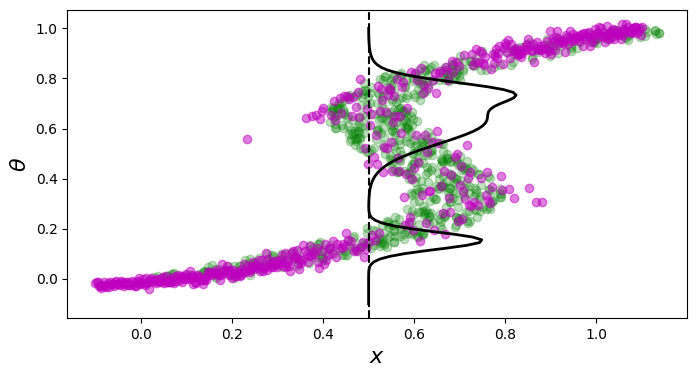

In [18]:
plt.figure(figsize=(8, 4))

plt.plot(x[::15], theta[::15], "go", alpha=0.25)
plt.plot(x_test, samples, "mo", alpha=0.5)
plt.plot(
    demo_probs.numpy() * 0.1 + x_demo.numpy(),
    torch.linspace(-0.1, 1, 100),
    linewidth=2,
    color="black",
)
plt.axvline(x_demo.data[0, 0], color="black", linestyle="--")

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$\\theta$", fontsize=16)

plt.show()


## What are the limitations?

- Requires setting of hyperparameters: e.g. components
- Training often does not converge perfectly. 
- In practice, high-dimensional distributions might not be captured perfectly
- Normalizing flows, VAEs, and GANs are more flexible. However, Mixtures of Gaussians often allow for useful computations in closed form and are still sometimes used in practice.


## Acknowledgments

- Material is based on the [MLColab training](https://mlcolab.org/simulation-based-inference-for-scientific-discovery) on Simulation-based Inference <br/>
- Parts of the code from [Mike Dusenberry](https://mikedusenberry.com/mixture-density-networks)  <br/>
- Code of MDNs based on Conor Durkan's `lfi` package.  <br/>
- Bishop, 1994  <br/>
- [MDN graphic](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)  
- Pedro Gonçalves et al. for figure.

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>